#  Import Libraries

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

nltk.download('stopwords')
nltk.download('wordnet')

from datetime import datetime
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, precision_score,recall_score,f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.preprocessing import MinMaxScaler

from IPython.display import clear_output
clear_output()

import warnings
warnings.filterwarnings("ignore")

# Data Understanding and preprocessing 

## Read the data

In [2]:
data = pd.read_csv('data/sample30.csv')
df = data.copy() #having data backup
data.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative


## Information on data

### Data description

| Column | Description |
| :- | :- |
|id | Uniques identity number to identify each unique review given by the user to a particular product in the dataset |
| brand | Name of the brand of the product to which user has given review and rating |
| categories | Category of the product like household essentials, books, personal care products, medicines, cosmetic items, beauty products, electrical appliances, kitchen and dining products, health care products and many more. |
| manufacturer | Name of the manufacturer of the product |
| name | Name of the product to which user has added review or rating |
| reviews_date | Date on which the review has been added by the user |
| reviews_didPurchase | Whether a particular user has purchased the product or not |
| reviews_doRecommend | Whether a particular user has recommended the product or not | 
| reviews_rating | Rating given by the user to a particular product |
| reviews_text  | Review given by the user to a particular product |
| reviews_title | The title of the review given by the user to a particular product |
| reviews_userCity | The residing city of the user |
| reviews_userProvince | The residing province of the user |
| reviews_username | The unique identification for individual user in the dataset |
| user_sentiment | The overall sentiment of the user for a particular product (Positive or Negative) |



### About data

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

In [4]:
data.shape

(30000, 15)

######  Observations: 

    1.Total columns - 15
    2.Total rows - 30000
    3.Target variable/dependent variable - user_sentiment
    4.Null values exists in few columns

In [5]:
data.describe()

,reviews_rating
count,30000.000000
mean,4.483133
std,0.988441
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


## Data Cleaning

### Handling missing values

In [6]:
#Find the number of missing values in each column
round(100*(data.isnull().sum().sort_values(ascending=False)/len(data.index)),4)


reviews_userProvince    99.4333
reviews_userCity        93.5700
reviews_didPurchase     46.8933
reviews_doRecommend      8.5667
reviews_title            0.6333
manufacturer             0.4700
reviews_username         0.2100
reviews_date             0.1533
user_sentiment           0.0033
id                       0.0000
brand                    0.0000
categories               0.0000
name                     0.0000
reviews_rating           0.0000
reviews_text             0.0000
dtype: float64

######  Observations: 
    1. Columns with high number of missing values - reviews_userProvince(99.4%), reviews_userCity(93.5%).
    2. Columns with moderate number of missing values - reviews_didPurchase(46.8%)
    3. Columns with low number of missing data - reviews_doRecommend(8.5%), reviews_title(0.63%), manufacturer(0.47%), 
    reviews_username(0.21%), reviews_date(0.15%), user_sentiment(0.0033%)

In [7]:
#Delete the columns with high number of missing values
data = data.drop(['reviews_userProvince', 'reviews_userCity'], axis = 1)


In [8]:
#Analysing column reviews_didPurchase

data['reviews_didPurchase'].value_counts()

False    14498
True      1434
Name: reviews_didPurchase, dtype: int64

In [9]:
data['reviews_didPurchase'].isnull().sum()

14068

###### Observations: 

The values in the column reviews_didPurchase are either True, False or NaN. Nearly half the records do not have the data for in this column. 
14498 records have value as False, and 1434 records have value as true. This is very imbalanced and does not yield much information. Hence, better to discard. 

In [10]:
data = data.drop(['reviews_didPurchase'], axis = 1)


In [11]:
#Analysing reviews_doRecommend

data['reviews_doRecommend'].value_counts()

True     25880
False     1550
Name: reviews_doRecommend, dtype: int64

In [12]:
#Filling the NaN values in reviews_doRecommend with frequently occuring value - mode 
data['reviews_doRecommend'].fillna(value=data['reviews_doRecommend'].mode()[0], inplace=True)


In [13]:
#Total missing records from 5 columns
data[['reviews_title','manufacturer','reviews_username','reviews_date','user_sentiment']].isnull().sum()

reviews_title       190
manufacturer        141
reviews_username     63
reviews_date         46
user_sentiment        1
dtype: int64

In [14]:
#The missing values in records from these 5 columns is very less, hence discard the records 
data.dropna(inplace=True)
data = data.reset_index(drop=True)

data.isnull().sum()

id                     0
brand                  0
categories             0
manufacturer           0
name                   0
reviews_date           0
reviews_doRecommend    0
reviews_rating         0
reviews_text           0
reviews_title          0
reviews_username       0
user_sentiment         0
dtype: int64

######  ------ Missing data successfully handled. ------  

### Handling Duplicates

In [15]:
#Check for duplicates
duplicates=data[data.duplicated(['reviews_username','id'])]
print(duplicates.shape)
duplicates.head(3)

(2343, 12)


,id,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,5,Good flavor.,Good,dorothy w,Positive
12,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-04-08T00:00:00.000Z,False,1,"Bought this to enhance our time a bit, did abs...",waste of money,jds1992,Negative
44,AV1h6Gu0glJLPUi8IjA_,Johnson's,"Personal Care,Baby Care,Baby Bubble Bath,Baby,...",Johnson's,"Johnson's Baby Bubble Bath and Wash, 15oz",2017-05-09T00:00:00.000Z,True,4,"Well, Johnson's need I say more I know, right....",2 in 1!!!,solo,Positive


In [16]:
#Remove duplicate records
data.drop_duplicates(subset=['id','reviews_username'], keep='first', inplace=True)
print(data.shape)
data.head(3)

(27223, 12)


,id,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,True,5,i love this album. it's very good. more to the...,Just Awesome,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,5,Good flavor. This review was collected as part...,Good,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,1,I read through the reviews on here before look...,Disappointed,rebecca,Negative


### Handling Data types


#### reviews_date



In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27223 entries, 0 to 29565
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   27223 non-null  object
 1   brand                27223 non-null  object
 2   categories           27223 non-null  object
 3   manufacturer         27223 non-null  object
 4   name                 27223 non-null  object
 5   reviews_date         27223 non-null  object
 6   reviews_doRecommend  27223 non-null  bool  
 7   reviews_rating       27223 non-null  int64 
 8   reviews_text         27223 non-null  object
 9   reviews_title        27223 non-null  object
 10  reviews_username     27223 non-null  object
 11  user_sentiment       27223 non-null  object
dtypes: bool(1), int64(1), object(10)
memory usage: 2.5+ MB


##### ------ The data type of the reviews_date is object, needs to be converted to datetime format -----

###### The data contains reviews_date in  two different formats -
    1. '%Y-%m-%dT%H:%M:%S.000Z'
    2. '%Y-%m-%dT%H:%M:%SZ'
    
Both these formats needs to be handled. 

In [18]:
#Convert the date column to datetime type and store it in column named - formatted_date

data['formatted_date'] = pd.to_datetime(data['reviews_date'], format='%Y-%m-%dT%H:%M:%S.000Z', errors='coerce') #First convert data in format 1 
mask = data.formatted_date.isnull() # mask will be true for the records which reviews_date is in format 2
data.loc[mask, 'formatted_date'] = pd.to_datetime(data[mask]['reviews_date'], format='%Y-%m-%dT%H:%M:%SZ',errors='coerce') # convert the reviews_date in format 2

In [19]:
#There could be records in which reviews_date dont match with both the formats, for such records formated_date will be null
data[data['formatted_date'].isnull()] 

,id,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment,formatted_date
28021,AVpfSFDo1cnluZ0-hwjT,Concept Housewares,"Kitchen & Dining,Kitchen Storage & Organizatio...",Group5 Mktg/Concept Housewares,Concept Housewares 36 Natural Wood ceiling mou...,hooks slide or swivel into any desired positi...,True,3,We moved into a home that already had this pot...,It matches what was already there.,hatestandinginlines,Positive,NaT
28022,AVpfSFDo1cnluZ0-hwjT,Concept Housewares,"Kitchen & Dining,Kitchen Storage & Organizatio...",Group5 Mktg/Concept Housewares,Concept Housewares 36 Natural Wood ceiling mou...,hooks slide or swivel into any desired positi...,True,5,Just bought one of these racks after first fin...,"Great little rack, amazing price",karenh2008,Positive,NaT
28023,AVpfSFDo1cnluZ0-hwjT,Concept Housewares,"Kitchen & Dining,Kitchen Storage & Organizatio...",Group5 Mktg/Concept Housewares,Concept Housewares 36 Natural Wood ceiling mou...,hooks slide or swivel into any desired positi...,True,5,Living in a townhome definitely has it's perks...,Perfect for my Townhome!,hellodanielle,Positive,NaT
28024,AVpfSFDo1cnluZ0-hwjT,Concept Housewares,"Kitchen & Dining,Kitchen Storage & Organizatio...",Group5 Mktg/Concept Housewares,Concept Housewares 36 Natural Wood ceiling mou...,hooks slide or swivel into any desired positi...,True,5,My daughter-in-law purchased this and I liked ...,Excellent Purchase,laurel,Positive,NaT
28025,AVpfSFDo1cnluZ0-hwjT,Concept Housewares,"Kitchen & Dining,Kitchen Storage & Organizatio...",Group5 Mktg/Concept Housewares,Concept Housewares 36 Natural Wood ceiling mou...,hooks slide or swivel into any desired positi...,True,5,Heavy duty - very durable-looking. Much more t...,great quality!,janet,Positive,NaT
28026,AVpfSFDo1cnluZ0-hwjT,Concept Housewares,"Kitchen & Dining,Kitchen Storage & Organizatio...",Group5 Mktg/Concept Housewares,Concept Housewares 36 Natural Wood ceiling mou...,hooks slide or swivel into any desired positi...,True,5,"I have a large kitchen, but over my stove wher...",ceiling pot rack,cookinmama2002,Positive,NaT
28027,AVpfSFDo1cnluZ0-hwjT,Concept Housewares,"Kitchen & Dining,Kitchen Storage & Organizatio...",Group5 Mktg/Concept Housewares,Concept Housewares 36 Natural Wood ceiling mou...,hooks slide or swivel into any desired positi...,True,5,These units are easy to assemble sturdy and of...,A Great Value,projectbound,Positive,NaT
28028,AVpfSFDo1cnluZ0-hwjT,Concept Housewares,"Kitchen & Dining,Kitchen Storage & Organizatio...",Group5 Mktg/Concept Housewares,Concept Housewares 36 Natural Wood ceiling mou...,hooks slide or swivel into any desired positi...,True,5,i love the pot rack. it was very easy to put t...,great product,chomie,Positive,NaT


In [20]:
data.isnull().sum()

id                     0
brand                  0
categories             0
manufacturer           0
name                   0
reviews_date           0
reviews_doRecommend    0
reviews_rating         0
reviews_text           0
reviews_title          0
reviews_username       0
user_sentiment         0
formatted_date         8
dtype: int64

###### The reviews_date for the above displayed 8 records does not contain date, So these records can be discarded. 

In [21]:
data.dropna(inplace=True)
data = data.reset_index(drop=True)
data.isnull().sum()

id                     0
brand                  0
categories             0
manufacturer           0
name                   0
reviews_date           0
reviews_doRecommend    0
reviews_rating         0
reviews_text           0
reviews_title          0
reviews_username       0
user_sentiment         0
formatted_date         0
dtype: int64

In [22]:
# replacing reviews_date with formated_date and renaming the column to reviews date, now it will be of type datetime
data['reviews_date'] = data['formatted_date']
data.drop(['formatted_date'],axis=1,inplace=True)
data.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30 06:21:45,True,5,i love this album. it's very good. more to the...,Just Awesome,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09 00:00:00,True,5,Good flavor. This review was collected as part...,Good,dorothy w,Positive
2,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06 00:00:00,False,1,I read through the reviews on here before look...,Disappointed,rebecca,Negative
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21 00:00:00,False,1,My husband bought this gel for us. The gel cau...,Irritation,walker557,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-04-20 00:00:00,False,1,My boyfriend and I bought this to spice things...,Not worth it,samantha,Negative


In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27215 entries, 0 to 27214
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   id                   27215 non-null  object        
 1   brand                27215 non-null  object        
 2   categories           27215 non-null  object        
 3   manufacturer         27215 non-null  object        
 4   name                 27215 non-null  object        
 5   reviews_date         27215 non-null  datetime64[ns]
 6   reviews_doRecommend  27215 non-null  bool          
 7   reviews_rating       27215 non-null  int64         
 8   reviews_text         27215 non-null  object        
 9   reviews_title        27215 non-null  object        
 10  reviews_username     27215 non-null  object        
 11  user_sentiment       27215 non-null  object        
dtypes: bool(1), datetime64[ns](1), int64(1), object(9)
memory usage: 2.3+ MB


In [24]:
print("Unique brands: ",len(data['brand'].unique()))
print("Unique manufacturers: ",len(data['manufacturer'].unique()))
print("Unique categories: ",len(data['categories'].unique()))
print("Unique users: ",len(data['id'].unique()))
print("Unique ratings: ",sorted(data['reviews_rating'].unique()))

Unique brands:  196
Unique manufacturers:  210
Unique categories:  248
Unique users:  248
Unique ratings:  [1, 2, 3, 4, 5]


### Review Class

Introducing 2 classes for reviews based on rating, 
1. Good: rating >= 3
2. Bad: rating < 3

In [25]:
##Apply the classification to the reviews_rating column
data['rating_class'] = data['reviews_rating'].apply(lambda x: 'bad' if x < 3 else'good')
data.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment,rating_class
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30 06:21:45,True,5,i love this album. it's very good. more to the...,Just Awesome,joshua,Positive,good
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09 00:00:00,True,5,Good flavor. This review was collected as part...,Good,dorothy w,Positive,good
2,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06 00:00:00,False,1,I read through the reviews on here before look...,Disappointed,rebecca,Negative,bad
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21 00:00:00,False,1,My husband bought this gel for us. The gel cau...,Irritation,walker557,Negative,bad
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-04-20 00:00:00,False,1,My boyfriend and I bought this to spice things...,Not worth it,samantha,Negative,bad


In [26]:
data['rating_class'].value_counts() 

good    25814
bad      1401
Name: rating_class, dtype: int64

## Text Preprocessing 
### review_Title and Review_text

#### Combine review_title and review_text

In [27]:
data['review'] = data['reviews_title'].map(str)+ " " + data['reviews_text']
data.drop(['reviews_title','reviews_text'], axis = 1, inplace = True)

#### Convert review to lower case and remove ounctuations

In [28]:
#Convert review to lower case and remove punctuations
data['review'] = data['review'].apply(lambda x : x.lower())
data['review'] = data['review'].str.replace('[^\w\s]', '')

In [29]:
data['review'][0]

'just awesome i love this album its very good more to the hip hop side than her current pop sound so hype i listen to this everyday at the gym i give it 5star rating all the way her metaphors are just crazy'

#### Removal of Stopwords

In [30]:
#Stopwards removal from Review
stop_words = stopwords.words('english')
data['review'] = data['review'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [31]:
data['review'][0]

'awesome love album good hip hop side current pop sound hype listen everyday gym give 5star rating way metaphors crazy'

#### Removal of non word characters and digits

In [32]:
#Remove non-wrd and digit characters
data['review'] = data['review'].str.replace('(\W|\d)', ' ')

In [33]:
data['review'] = data['review'].str.replace('(<.*?>)', '')

In [34]:
data['review'][0]

'awesome love album good hip hop side current pop sound hype listen everyday gym give  star rating way metaphors crazy'

#### Lemmatization

In [35]:
def word_lemmatizer(text):
    text=text.split(" ")
    lem_text = [WordNetLemmatizer().lemmatize(i) for i in text]
    new_text = " ".join(lem_text)
    return new_text

data['review'] = data['review'].apply(lambda x: word_lemmatizer(x))

In [36]:
data.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_username,user_sentiment,rating_class,review
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30 06:21:45,True,5,joshua,Positive,good,awesome love album good hip hop side current p...
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09 00:00:00,True,5,dorothy w,Positive,good,good good flavor review collected part promotion
2,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06 00:00:00,False,1,rebecca,Negative,bad,disappointed read review looking buying one co...
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21 00:00:00,False,1,walker557,Negative,bad,irritation husband bought gel u gel caused irr...
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-04-20 00:00:00,False,1,samantha,Negative,bad,worth boyfriend bought spice thing bedroom hig...


### Brand and manufacturer

#### Removing punctuations

In [37]:
data['brand'] = data['brand'].str.replace('[^\w\s]', '')
data['manufacturer'] = data['manufacturer'].str.replace('[^\w\s]', '')

#### Convert to lowercase

In [38]:
data['brand'] = data['brand'].apply(lambda x : x.lower())
data['manufacturer'] = data['manufacturer'].apply(lambda x : x.lower())

In [39]:
data[['brand','manufacturer']].head(10)

,brand,manufacturer
0,universal music,universal music group cash money
1,lundberg,lundberg
2,ky,ky
3,ky,ky
4,ky,ky
5,ky,ky
6,ky,ky
7,ky,ky
8,ky,ky
9,ky,ky


In [40]:
data[['brand','manufacturer']].tail(10)

,brand,manufacturer
27205,loreal paris,loreal paris
27206,loreal paris,loreal paris
27207,loreal paris,loreal paris
27208,loreal paris,loreal paris
27209,loreal paris,loreal paris
27210,loreal paris,loreal paris
27211,loreal paris,loreal paris
27212,loreal paris,loreal paris
27213,loreal paris,loreal paris
27214,loreal paris,loreal paris


##### The brand and manufacturer have the same value in the above observations, let's check in how many records the brand and manufacturer have same/different values

In [41]:
#brand and manufacturer with different values
bm_diff = data[~(data['brand']==data['manufacturer'])]
print(bm_diff.shape)
bm_diff[['brand','manufacturer']].head()

(14937, 12)


,brand,manufacturer
0,universal music,universal music group cash money
34,ambi,fleming co
35,ambi,fleming co
36,ambi,fleming co
37,ambi,fleming co


In [42]:
#brand and manufacturer with same values
bm_same = data[(data['brand']==data['manufacturer'])]
print(bm_same.shape)
bm_same[['brand','manufacturer']].head()

(12278, 12)


,brand,manufacturer
1,lundberg,lundberg
2,ky,ky
3,ky,ky
4,ky,ky
5,ky,ky


##### We can observe that approximately half the records have (brand,manufacturer) different and other half are same. 

## Unique values count

In [43]:
print("Unique brands: ",len(data['brand'].unique()))
print("Unique manufacturers: ",len(data['manufacturer'].unique()))
print("Unique categories: ",len(data['categories'].unique()))
print("Unique users: ",len(data['id'].unique()))
print("Unique ratings: ",sorted(data['reviews_rating'].unique()))

Unique brands:  195
Unique manufacturers:  206
Unique categories:  248
Unique users:  248
Unique ratings:  [1, 2, 3, 4, 5]


# Exploratory data Analysis

In [44]:
data.columns

Index(['id', 'brand', 'categories', 'manufacturer', 'name', 'reviews_date',
       'reviews_doRecommend', 'reviews_rating', 'reviews_username',
       'user_sentiment', 'rating_class', 'review'],
      dtype='object')

## Most recommended product

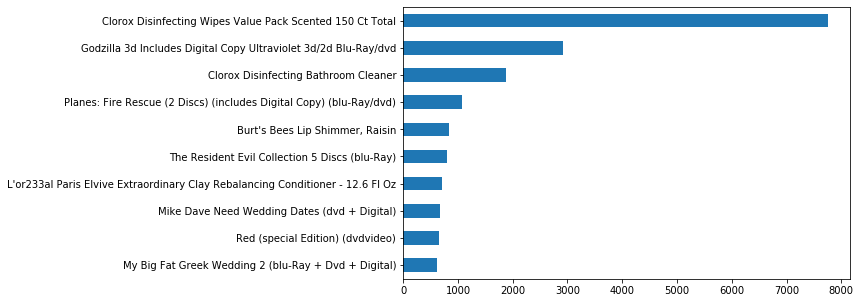

In [45]:
recommended = data[data['reviews_doRecommend'] == True]
recommended['name'].value_counts()[0:10].plot(kind = 'barh', figsize=[8,5], fontsize=10).invert_yaxis()

##### "Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total" is the most recommended product

## Reviews Date

In [46]:
data['Year'] = data['reviews_date'].dt.year
data['Month'] = data['reviews_date'].dt.month

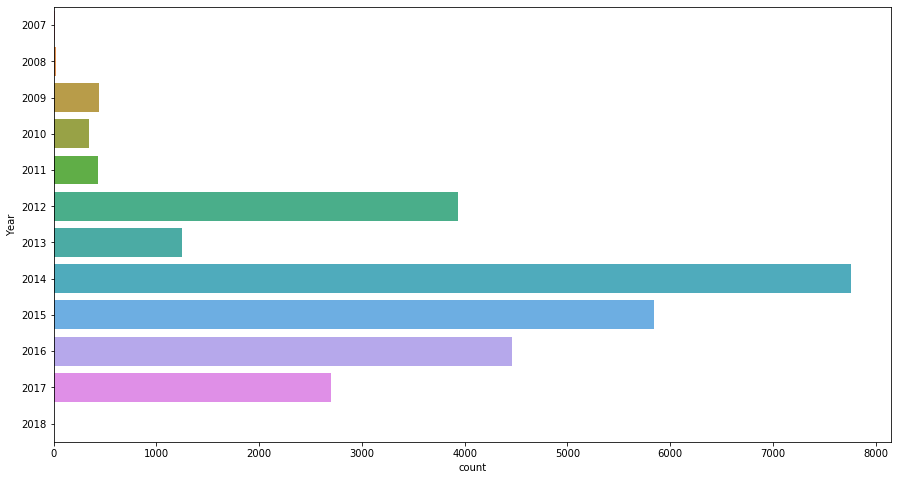

In [47]:
plt.figure(figsize=(15,8))
sns.countplot(y=data['Year'])

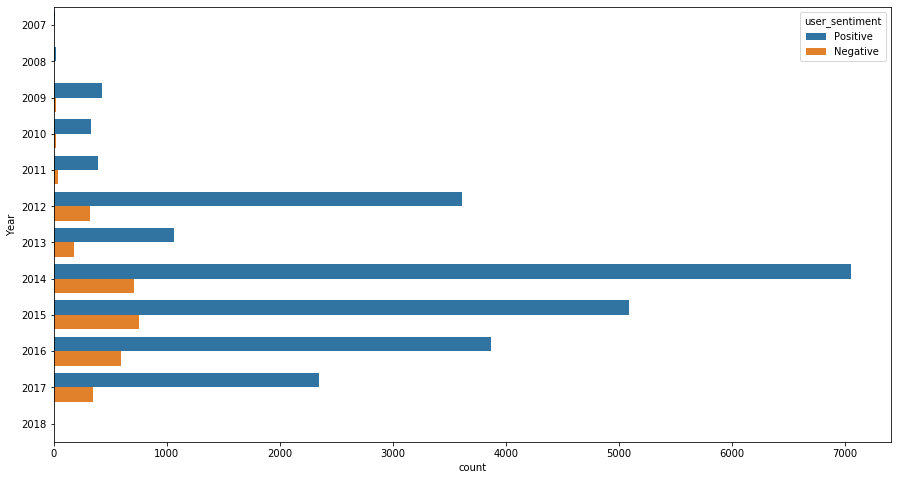

In [48]:
plt.figure(figsize=(15,8))
sns.countplot(y=data['Year'], hue=data['user_sentiment'])

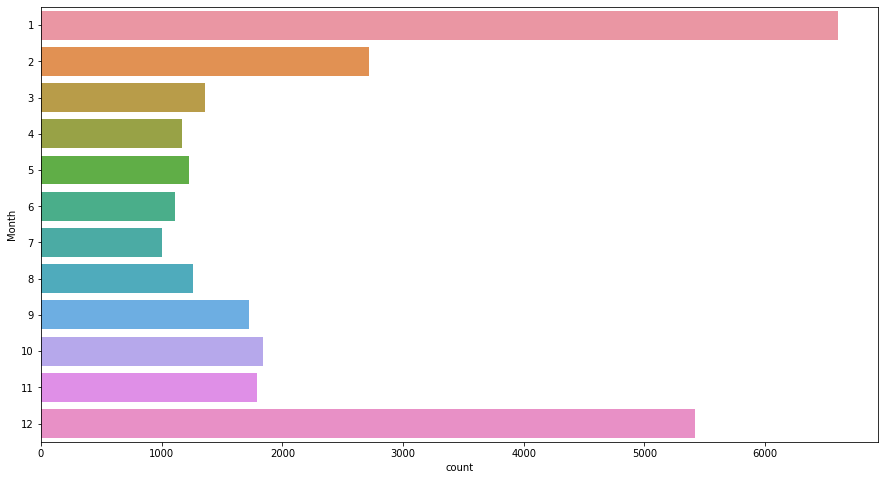

In [49]:
plt.figure(figsize=(15,8))
sns.countplot(y=data['Month'])

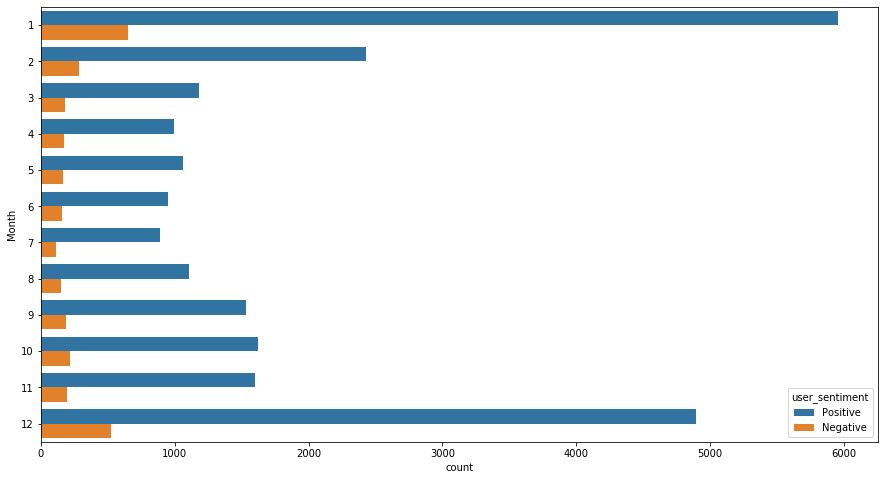

In [50]:
plt.figure(figsize=(15,8))
sns.countplot(y=data['Month'], hue=data['user_sentiment'])

##### Observation:
1. There is a significant rise in the year 2012 and it drops drastically in 2013. The reviews is 7 times more in 2014 than 2013 and reduces gradually henceforth
2. There is a significant rise in the number of reviews in the month of December and January. 

In [51]:
data.groupby(['Year'])['reviews_rating'].value_counts()

Year  reviews_rating
2007  5                   10
2008  5                   12
      4                    4
      2                    2
      1                    1
2009  5                  333
      4                   89
      3                   13
      2                    6
      1                    4
2010  5                  264
      4                   59
      1                   13
      3                    8
      2                    4
2011  5                  289
      4                   89
      3                   22
      1                   16
      2                   14
2012  5                 3373
      4                  455
      3                   49
      1                   44
      2                   19
2013  5                  816
      4                  283
      1                   65
      3                   57
      2                   32
2014  5                 5470
      4                 1759
      3                  345
      1               

## Brands

Text(0, 0.5, 'Brand')

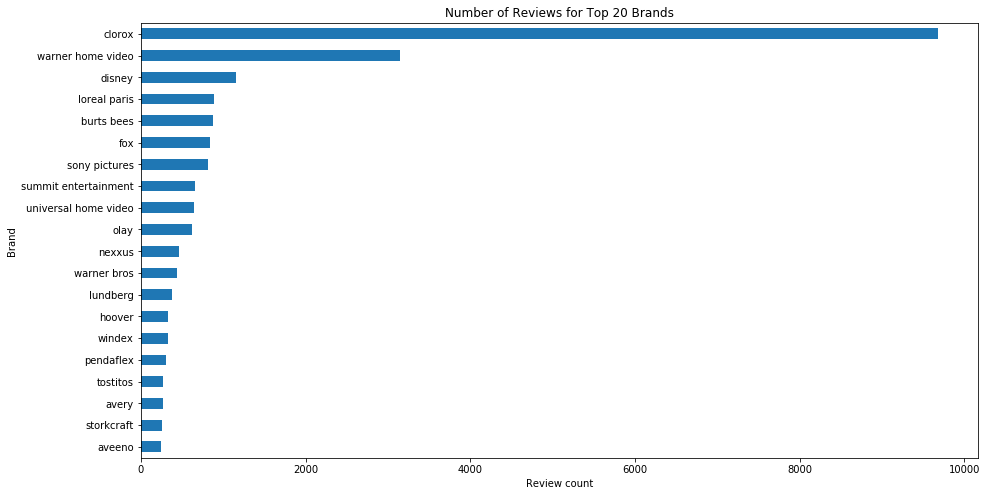

In [52]:
#top 20 brands and their review counts
plt.figure(figsize=(15,8))
data['brand'].value_counts()[0:20].sort_values().plot(kind = 'barh')
plt.title("Number of Reviews for Top 20 Brands")
plt.xlabel('Review count')
plt.ylabel('Brand')

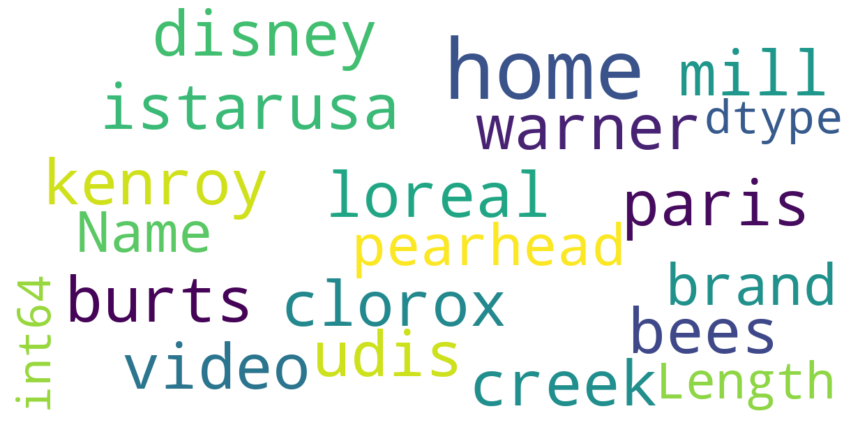

In [53]:
#word cloud
stopwords = set(STOPWORDS)

wordcloud = WordCloud(background_color='white', stopwords=stopwords, max_words=300, max_font_size=40,
                     scale=3, random_state=1).generate(str(data['brand'].value_counts()))
plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Categories

Text(0, 0.5, 'Review count')

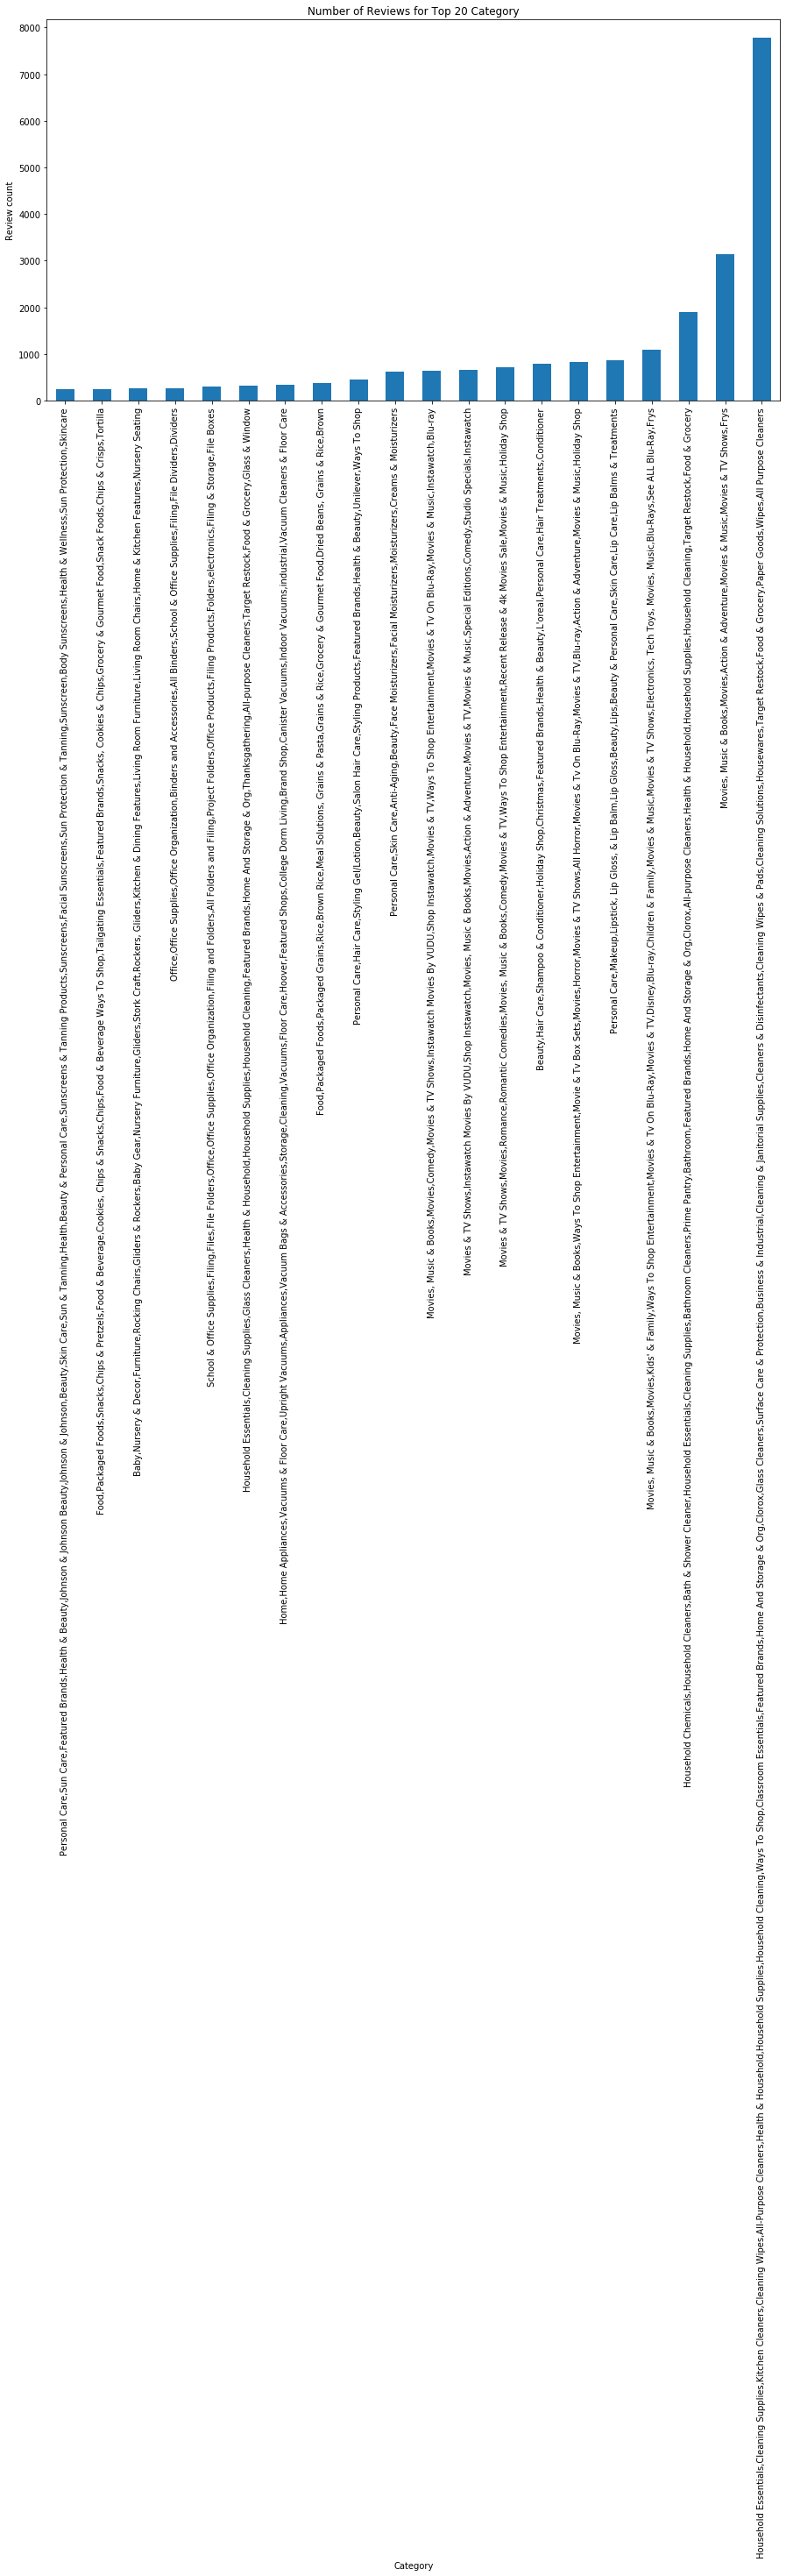

In [54]:
#top 20 brands and their review counts
plt.figure(figsize=(15,8))
data['categories'].value_counts()[0:20].sort_values().plot(kind = 'bar')
plt.title("Number of Reviews for Top 20 Category")
plt.xlabel('Category')
plt.ylabel('Review count')

## Manufacturer

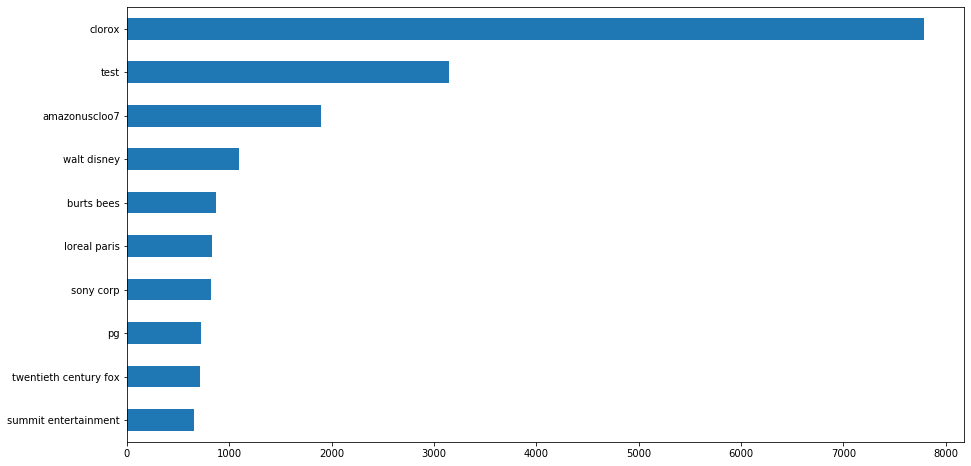

In [55]:
plt.figure(figsize=(15,8))
data['manufacturer'].value_counts()[0:10].sort_values().plot(kind = 'barh')

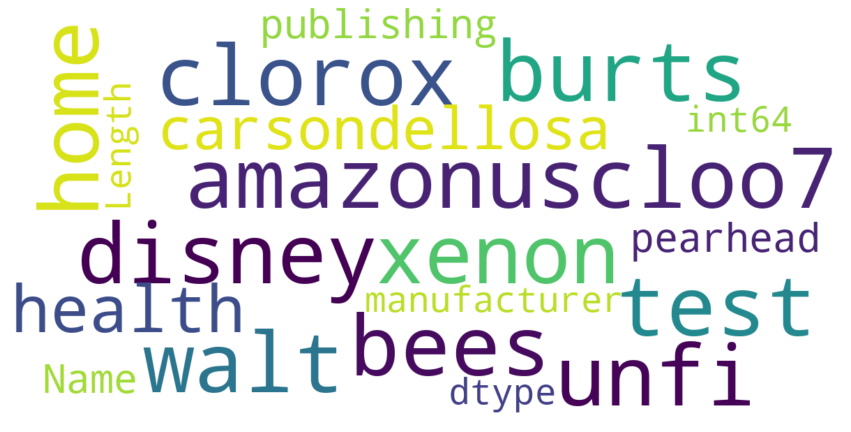

In [56]:
stopwords = set(STOPWORDS)

wordcloud = WordCloud(background_color='white', stopwords=stopwords, max_words=300, max_font_size=40,
                     scale=3, random_state=1).generate(str(data['manufacturer'].value_counts()))
plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Reviews Rating

In [57]:
##Classify ratings as good and bad
good_rate = len(data[data['reviews_rating'] >= 3])
bad_rate = len(data[data['reviews_rating'] < 3])

# Printing rates and their total numbers
print ('Good ratings : ', good_rate)
print ('Bad ratings : ',format(bad_rate))

Good ratings :  25814
Bad ratings :  1401


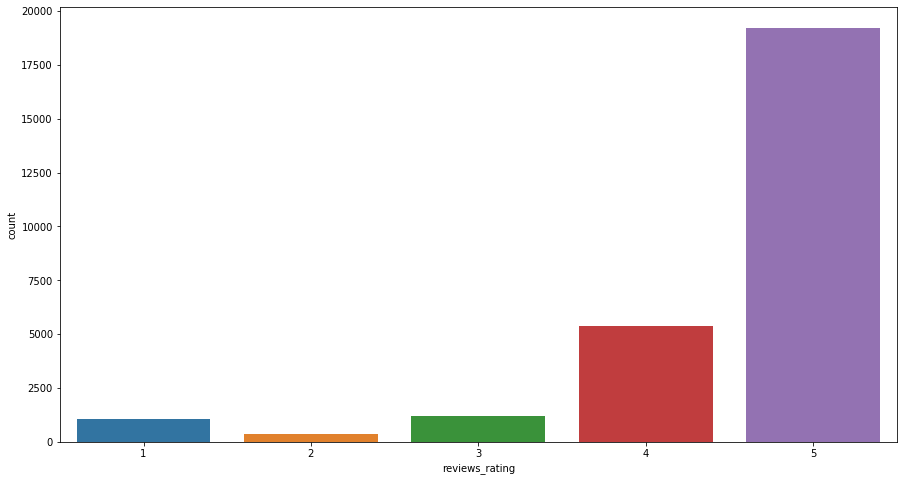

In [58]:
plt.figure(figsize=(15,8))
sns.countplot(data['reviews_rating'])

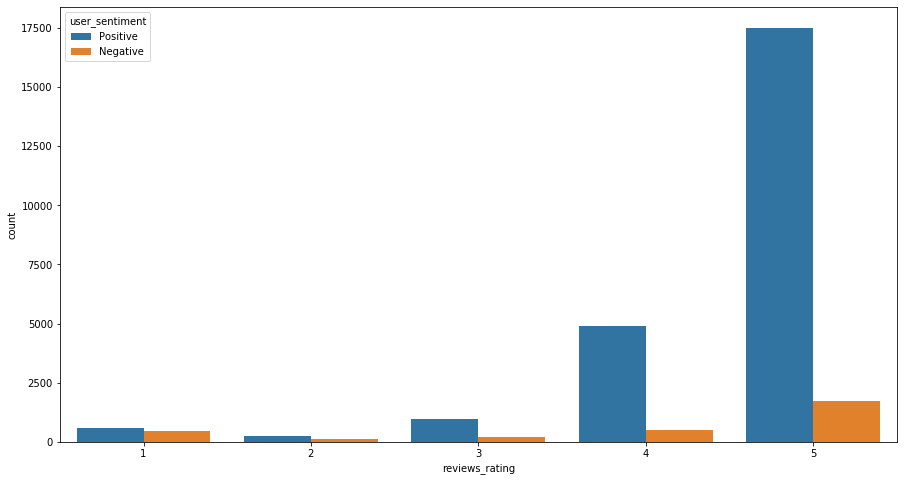

In [59]:
plt.figure(figsize=(15,8))
sns.countplot(data['reviews_rating'], hue=data['user_sentiment'])

##### Observation:
Many users have given a rating of 5 to products followed by 4, 3 and 1 whereas very few users have given a low rating of 2

## Rating class

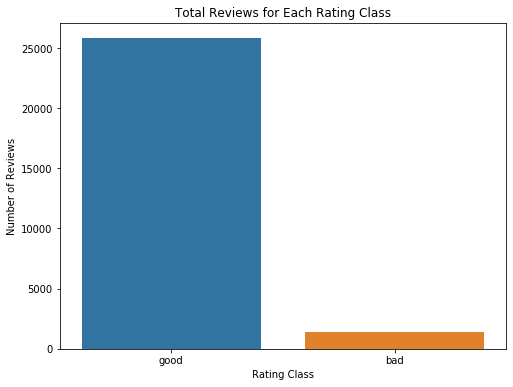

In [60]:
plt.figure(figsize = (8,6))
sns.countplot(data['rating_class'])
plt.title('Total Reviews for Each Rating Class')
plt.xlabel('Rating Class')
plt.ylabel('Number of Reviews')
plt.show()

## Review

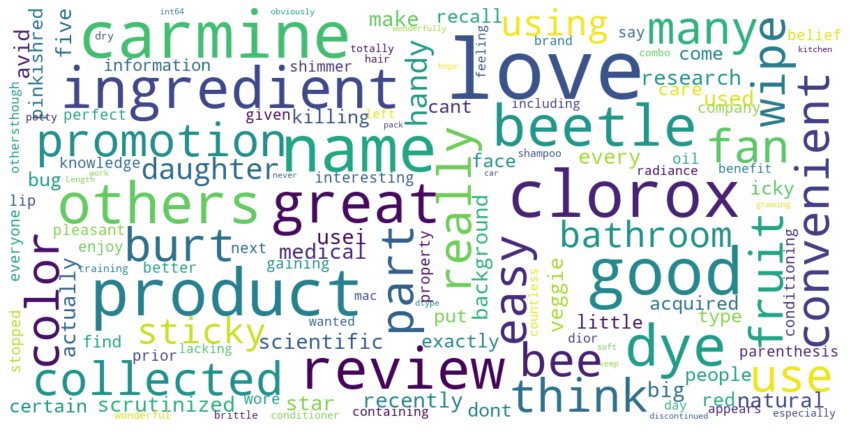

In [61]:
stopwords = set(STOPWORDS)

wordcloud = WordCloud(background_color='white', stopwords=stopwords, max_words=300, max_font_size=40,
                     scale=3, random_state=1).generate(str(data['review'].value_counts()))
plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [62]:
data.columns


Index(['id', 'brand', 'categories', 'manufacturer', 'name', 'reviews_date',
       'reviews_doRecommend', 'reviews_rating', 'reviews_username',
       'user_sentiment', 'rating_class', 'review', 'Year', 'Month'],
      dtype='object')

In [63]:
data.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_username,user_sentiment,rating_class,review,Year,Month
0,AV13O1A8GV-KLJ3akUyj,universal music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",universal music group cash money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30 06:21:45,True,5,joshua,Positive,good,awesome love album good hip hop side current p...,2012,11
1,AV14LG0R-jtxr-f38QfS,lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09 00:00:00,True,5,dorothy w,Positive,good,good good flavor review collected part promotion,2017,7
2,AV16khLE-jtxr-f38VFn,ky,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",ky,K-Y Love Sensuality Pleasure Gel,2016-01-06 00:00:00,False,1,rebecca,Negative,bad,disappointed read review looking buying one co...,2016,1
3,AV16khLE-jtxr-f38VFn,ky,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",ky,K-Y Love Sensuality Pleasure Gel,2016-12-21 00:00:00,False,1,walker557,Negative,bad,irritation husband bought gel u gel caused irr...,2016,12
4,AV16khLE-jtxr-f38VFn,ky,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",ky,K-Y Love Sensuality Pleasure Gel,2016-04-20 00:00:00,False,1,samantha,Negative,bad,worth boyfriend bought spice thing bedroom hig...,2016,4


In [64]:
data['user_sentiment'] = data['user_sentiment'].apply(lambda x: 1 if x == 'Positive' else 0)

In [65]:
data.columns

Index(['id', 'brand', 'categories', 'manufacturer', 'name', 'reviews_date',
       'reviews_doRecommend', 'reviews_rating', 'reviews_username',
       'user_sentiment', 'rating_class', 'review', 'Year', 'Month'],
      dtype='object')

In [66]:
trimmed_data = data[['id','name','brand','categories','manufacturer','reviews_rating','review', 'user_sentiment']]
pickle.dump(trimmed_data, open('trimmed_data.pkl', 'wb'))

# Model Building 

## Feature extraction

In [67]:
tfidf_vectorizer = TfidfVectorizer(max_features = 10000, ngram_range = (1, 3), token_pattern=r'\w{1,}')
tfidf_vectorizer.fit(data["review"])

X = tfidf_vectorizer.transform(data["review"])
y = data["user_sentiment"]

# Saving the vocabulary used in tfidf vectorizer as features
pickle.dump(tfidf_vectorizer.vocabulary_, open("vocab_features.pkl","wb"))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

## Handling Class Imbalance

In [68]:
data['user_sentiment'].value_counts()

1    24214
0     3001
Name: user_sentiment, dtype: int64

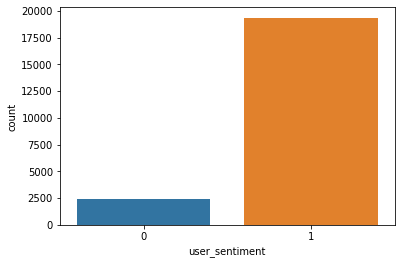

In [69]:
sns.countplot(y_train)
plt.show()

In [70]:
# Handling class imbalance using SMOTE
counter = Counter(y_train)
print("Before: ", counter)

#oversampling using SMOTE
smote = SMOTE()
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

counter = Counter(y_train_sm)
print("After: ", counter)

Before:  Counter({1: 19357, 0: 2415})
After:  Counter({1: 19357, 0: 19357})


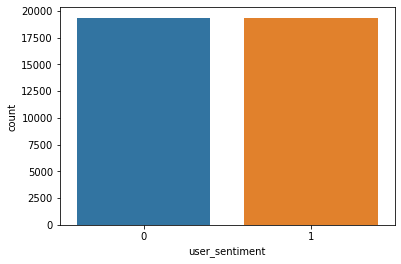

In [71]:
sns.countplot(y_train_sm)
plt.show()

In [72]:
def getPerformanceMetrics(classifier):
    cm = confusion_matrix(y_test, classifier.predict(X_test))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
    disp.plot() 
    print(classifier)
    print('\n')
    print('Accuracy: ', accuracy_score(y_test, classifier.predict(X_test)))
    print('Sensitivity: {}'.format(cm[1][1]/sum(cm[1])))
    print('Specificity: {}'.format(cm[0][0]/sum(cm[0])))
    print('Precision: ', precision_score(y_test, classifier.predict(X_test)))
    print('Recall: ', recall_score(y_test, classifier.predict(X_test)))
    print('F1 Score: ', f1_score(y_test, classifier.predict(X_test)))

## Model - 1: Logistic Regression

In [73]:
for c in [0.01, 0.05, 0.25, 0.5]:
    
    lr = LogisticRegression(C=c)
    lr.fit(X_train_sm, y_train_sm)
    cm = confusion_matrix(y_test, lr.predict(X_test))
    print('\nSensitivity for C = {0} is {1}'.format(c, cm[1][1]/sum(cm[1])))
    print('Specificity for C = {0} is {1}'.format(c, cm[0][0]/sum(cm[0])))


Sensitivity for C = 0.01 is 0.8177887584928969
Specificity for C = 0.01 is 0.742320819112628

Sensitivity for C = 0.05 is 0.830142063001853
Specificity for C = 0.05 is 0.7747440273037542

Sensitivity for C = 0.25 is 0.8589664401894174
Specificity for C = 0.25 is 0.7747440273037542

Sensitivity for C = 0.5 is 0.8750257360510604
Specificity for C = 0.5 is 0.7679180887372014


In [74]:
#Choosing c=0.05

lr = LogisticRegression(C=0.05)
lr.fit(X_train_sm, y_train_sm)

LogisticRegression(C=0.05)

LogisticRegression(C=0.05)


Accuracy:  0.824177843101231
Sensitivity: 0.830142063001853
Specificity: 0.7747440273037542
Precision:  0.968299711815562
Recall:  0.830142063001853
F1 Score:  0.8939142001995344


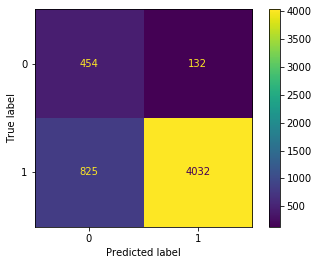

In [75]:
#Performance Metrics for Logistic Regression

getPerformanceMetrics(lr)

## Model - 2: Random Forest Classifier

In [76]:
param_grid = {
    'max_depth': [10, 15, 20],
    'min_samples_leaf': [50, 100, 150, 200],
    'min_samples_split': [100, 200,300, 400],
    'n_estimators': [100, 200, 300]
}

rfc = RandomForestClassifier()

rfc = GridSearchCV(estimator = rfc, param_grid = param_grid, scoring='roc_auc', cv = 3,verbose = 1)
rfc.fit(X_train_sm, y_train_sm)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 432 out of 432 | elapsed: 26.7min finished


GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [10, 15, 20],
                         'min_samples_leaf': [50, 100, 150, 200],
                         'min_samples_split': [100, 200, 300, 400],
                         'n_estimators': [100, 200, 300]},
             scoring='roc_auc', verbose=1)

In [77]:
print("best Score: ", rfc.best_score_)
print("best params: ", rfc.best_params_)

best Score:  0.904729881954165
best params:  {'max_depth': 20, 'min_samples_leaf': 50, 'min_samples_split': 100, 'n_estimators': 300}


GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [10, 15, 20],
                         'min_samples_leaf': [50, 100, 150, 200],
                         'min_samples_split': [100, 200, 300, 400],
                         'n_estimators': [100, 200, 300]},
             scoring='roc_auc', verbose=1)


Accuracy:  0.8298732316737093
Sensitivity: 0.8593782170063825
Specificity: 0.5853242320819113
Precision:  0.9449852841294997
Recall:  0.8593782170063825
F1 Score:  0.9001509596722019


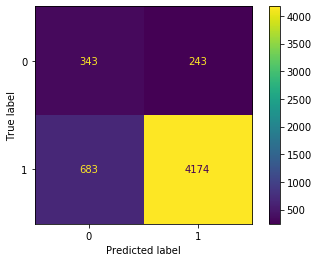

In [78]:
#Performance metrics for Random forest Classifier

getPerformanceMetrics(rfc)

## Model - 3: Naive Bayes Classifier



In [79]:
nb = MultinomialNB()
nb.fit(X_train_sm, y_train_sm)

MultinomialNB()

MultinomialNB()


Accuracy:  0.8318941760058791
Sensitivity: 0.8529956763434219
Specificity: 0.6569965870307167
Precision:  0.9537292817679558
Recall:  0.8529956763434219
F1 Score:  0.9005542875774373


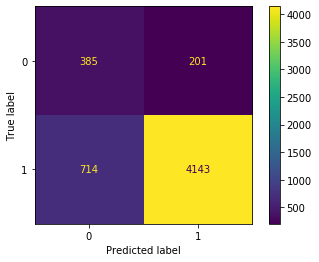

In [80]:
#Performance metrics for naive Bayes Classifier

getPerformanceMetrics(nb)

## Model - 4: XG Boost

In [81]:
param_grid = {
    'learning_rate': [0.001, 0.01], 
    'max_depth':[10, 15],  
    'n_estimators':[100, 200, 300]}

final_xgb = XGBClassifier(booster='gbtree')

# set up GridSearchCV()
xgb_tuned = GridSearchCV(estimator = final_xgb, 
                        param_grid = param_grid, 
                        scoring= 'roc_auc', 
                        cv = 3, 
                        verbose = 1,
                        return_train_score=True)

xgb_tuned.fit(X_train_sm, y_train_sm)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed: 40.6min finished


GridSearchCV(cv=3, estimator=XGBClassifier(),
             param_grid={'learning_rate': [0.001, 0.01], 'max_depth': [10, 15],
                         'n_estimators': [100, 200, 300]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [82]:
print("best Score: ", xgb_tuned.best_score_)
print("best params: ", xgb_tuned.best_params_)

best Score:  0.9578993678716471
best params:  {'learning_rate': 0.01, 'max_depth': 15, 'n_estimators': 300}


GridSearchCV(cv=3, estimator=XGBClassifier(),
             param_grid={'learning_rate': [0.001, 0.01], 'max_depth': [10, 15],
                         'n_estimators': [100, 200, 300]},
             return_train_score=True, scoring='roc_auc', verbose=1)


Accuracy:  0.8583501745361014
Sensitivity: 0.8910850319127033
Specificity: 0.5870307167235495
Precision:  0.9470459518599562
Recall:  0.8910850319127033
F1 Score:  0.9182136416675507


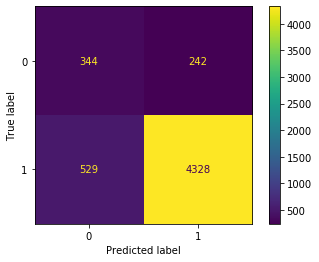

In [83]:
getPerformanceMetrics(xgb_tuned)

## Models Performance Summary

| Model | Accuracy | Sensitivity | Specificity | Precision | Recall | F1 Score |
| :-: | :-: | :-: | :-: | :-: | :-: | :-: |
| Logistic Regression | 0.824 | 0.830 | 0.774 | 0.968 | 0.830
| Random Forest | 0.829 | 0.859 | 0.583 | 0.944 | 0.859 | 0.900 |
| Naive Bayes | 0.831 | 0.852 | 0.658 | 0.953 | 0.853 | 0.900 |
| XGBoost | 0.857 | 0.889 | 0.590 | 0.947 | 0.891 | 0.918 |



The Logistic regression model performs better, will be using that ahead. 

In [84]:
prediction = lr.predict(X)

In [85]:
prediction_df =pd.DataFrame(prediction, columns=['Predicted_sentiment'])
prediction_df['Actual_sentiment'] = data['user_sentiment']
prediction_df.head(20)

,Predicted_sentiment,Actual_sentiment
0,1,1
1,1,1
2,0,0
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,1
9,0,0


In [86]:
accuracy = round(accuracy_score(prediction_df['Actual_sentiment'],prediction_df['Predicted_sentiment']), 3)
precision = round(precision_score(prediction_df['Actual_sentiment'],prediction_df['Predicted_sentiment']), 3)
recall = round(recall_score(prediction_df['Actual_sentiment'],prediction_df['Predicted_sentiment']), 3)
f1 = round(f1_score(prediction_df['Actual_sentiment'],prediction_df['Predicted_sentiment']), 3)
print("Perfomance metrics: ")
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)

Perfomance metrics: 
Accuracy:  0.839
Precision:  0.977
Recall:  0.839
F1 Score:  0.902


In [87]:
data['predicted_sentiment'] = prediction_df['Predicted_sentiment']

In [88]:
# Save the best trained model as a pickle string.
saved_model = pickle.dump(lr, open('logistic_regression_v1.pkl', 'wb'))

In [89]:
data.to_csv('data/updated_sample30_v1.csv', index=False)

# Recommendation System 
- User based recommendation
- User based prediction & evaluation
- Item based recommendation
- Item based prediction & evaluation

In [90]:
data = pd.read_csv('data/updated_sample30_v1.csv')
data.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_username,user_sentiment,rating_class,review,Year,Month,predicted_sentiment
0,AV13O1A8GV-KLJ3akUyj,universal music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",universal music group cash money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30 06:21:45,True,5,joshua,1,good,awesome love album good hip hop side current p...,2012,11,1
1,AV14LG0R-jtxr-f38QfS,lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09 00:00:00,True,5,dorothy w,1,good,good good flavor review collected part promotion,2017,7,1
2,AV16khLE-jtxr-f38VFn,ky,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",ky,K-Y Love Sensuality Pleasure Gel,2016-01-06 00:00:00,False,1,rebecca,0,bad,disappointed read review looking buying one co...,2016,1,0
3,AV16khLE-jtxr-f38VFn,ky,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",ky,K-Y Love Sensuality Pleasure Gel,2016-12-21 00:00:00,False,1,walker557,0,bad,irritation husband bought gel u gel caused irr...,2016,12,0
4,AV16khLE-jtxr-f38VFn,ky,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",ky,K-Y Love Sensuality Pleasure Gel,2016-04-20 00:00:00,False,1,samantha,0,bad,worth boyfriend bought spice thing bedroom hig...,2016,4,0


In [91]:
ratings = data[['id','reviews_rating','reviews_username']]
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27215 entries, 0 to 27214
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                27215 non-null  object
 1   reviews_rating    27215 non-null  int64 
 2   reviews_username  27215 non-null  object
dtypes: int64(1), object(2)
memory usage: 638.0+ KB


## User based

### Dividing dataset into train and test

In [92]:
train, test = train_test_split(ratings, test_size=0.30, random_state=31)
print(train.shape)
print(test.shape)

(19050, 3)
(8165, 3)


In [93]:
# Pivot the train ratings' dataset into matrix format in which columns are productId and the rows are usernames.
df_pivot = train.pivot(
    index='reviews_username',
    columns='id',
    values='reviews_rating'
).fillna(0)

df_pivot.head(3)

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0325home,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Creating dummy train & dummy test dataset

These dataset will be used for prediction 

- Dummy train will be used later for prediction of the movies which has not been rated by the user. To ignore the movies rated by the user, we will mark it as 0 during prediction. The movies not rated by user is marked as 1 for prediction in dummy train dataset. 

- Dummy test will be used for evaluation. To evaluate, we will only make prediction on the movies rated by the user. So, this is marked as 1. This is just opposite of dummy_train

In [94]:
# Copy the train dataset into dummy_train
dummy_train = train.copy()

In [95]:
# The products not rated by user is marked as 1 for prediction. 
dummy_train['reviews_rating'] = dummy_train['reviews_rating'].apply(lambda x: 0 if x>=1 else 1)

In [96]:
dummy_train = dummy_train.pivot(
    index='reviews_username',
    columns='id',
    values='reviews_rating'
).fillna(1)

dummy_train.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
00sab00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
0325home,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
06stidriver,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
08dallas,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


**Cosine Similarity**

Cosine Similarity is a measurement that quantifies the similarity between two vectors [Which is Rating Vector in this case] 

**Adjusted Cosine**

Adjusted cosine similarity is a modified version of vector-based similarity where we incorporate the fact that different users have different ratings schemes. In other words, some users might rate items highly in general, and others might give items lower ratings as a preference. To handle this nature from rating given by user , we subtract average ratings for each user from each user's rating for different products.



### User Similarity Matrix

#### Using Cosine Similarity

In [97]:
df_pivot.index.nunique()

17617

In [98]:
# Creating the User Similarity Matrix using pairwise_distance function.
user_correlation = 1 - pairwise_distances(df_pivot, metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[1.        0.        0.        ... 0.        0.        0.       ]
 [0.        1.        0.        ... 0.        0.        0.9486833]
 [0.        0.        1.        ... 1.        1.        0.       ]
 ...
 [0.        0.        1.        ... 1.        1.        0.       ]
 [0.        0.        1.        ... 1.        1.        0.       ]
 [0.        0.9486833 0.        ... 0.        0.        1.       ]]


In [99]:
user_correlation.shape

(17617, 17617)

#### Using adjusted Cosine

Here, we are not removing the NaN values and calculating the mean only for the products rated by the user

In [100]:
# Create a user-product matrix.
df_pivot = train.pivot_table(
    index='reviews_username',
    columns='id',
    values='reviews_rating'
)

In [101]:
df_pivot.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0325home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
06stidriver,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
08dallas,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Normalising the rating of the products for each user around 0 mean

In [102]:
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T

In [103]:
df_subtracted.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0325home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
06stidriver,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
08dallas,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Finding Cosine Similarity

In [104]:
# Creating the User Similarity Matrix using pairwise_distance function.
user_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [105]:
user_correlation.shape

(17617, 17617)

### Prediction - User User

Doing the prediction for the users which are positively related with other users, and not the users which are negatively related as we are interested in the users which are more similar to the current users. So, ignoring the correlation for values less than 0. 

In [106]:
user_correlation[user_correlation<0]=0
user_correlation

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Rating predicted by the user (for products rated as well as not rated) is the weighted sum of correlation with the product rating (as present in the rating dataset). 

In [107]:
user_predicted_ratings = np.dot(user_correlation, df_pivot.fillna(0))
user_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.97385508],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [108]:
user_predicted_ratings.shape

(17617, 232)

Since we are interested only in the products not rated by the user, we will ignore the products rated by the user by making it zero.



In [109]:
user_final_rating = np.multiply(user_predicted_ratings,dummy_train)
user_final_rating.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.645497,...,1.834498,0.237171,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.973855
0325home,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
06stidriver,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
08dallas,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000



#### Finding the top 20 recommendations for the *user*

In [110]:
d = user_final_rating.loc['00sab00'].sort_values(ascending=False)[0:20]
d

id
AVpfRTh1ilAPnD_xYic2    38.407083
AVpfPaoqLJeJML435Xk9    25.912501
AVpf0eb2LJeJML43EVSt    13.023168
AVpf2tw1ilAPnD_xjflC    13.010476
AVpf3VOfilAPnD_xjpun     7.475624
AVpfJP1C1cnluZ0-e3Xy     5.180815
AVpfBrUZilAPnD_xTUly     3.625604
AVpfPnrU1cnluZ0-g9rL     3.461994
AVpf5Z1zLJeJML43FpB-     3.460371
AVpfm8yiLJeJML43AYyu     3.257085
AVpfazX31cnluZ0-kbdl     3.020621
AVpf--o9LJeJML43G_Fq     2.972421
AVpfe3On1cnluZ0-lgn5     2.886751
AVpfMpZ51cnluZ0-f_L9     2.535463
AVpfUJu_ilAPnD_xZdDr     2.500000
AVpf63aJLJeJML43F__Q     2.500000
AVpfov9TLJeJML43A7B0     2.439750
AVpfKOYiilAPnD_xWOFw     2.439750
AVpfD9xTLJeJML431ig2     2.439750
AVpf0thK1cnluZ0-r8vR     2.041241
Name: 00sab00, dtype: float64

### Evaluation - User User

Evaluation will we same as you have seen above for the prediction. The only difference being, you will evaluate for the products already rated by the user insead of predicting it for the products not rated by the user. 

In [111]:
# Find out the common users of test and train dataset.
common = test[test.reviews_username.isin(train.reviews_username)]
common.shape

(1022, 3)

In [112]:
common.head()

,id,reviews_rating,reviews_username
23444,AVpfPaoqLJeJML435Xk9,5,movie
11257,AVpf3VOfilAPnD_xjpun,5,cami
1951,AVpe41TqilAPnD_xQH3d,4,mugs
774,AV1YGDqsGV-KLJ3adc-O,4,betty
7823,AVpf3VOfilAPnD_xjpun,5,moocow


In [113]:
# convert into the user-movie matrix.
common_user_based_matrix = common.pivot_table(index='reviews_username', columns='id', values='reviews_rating')

In [114]:
# Convert the user_correlation matrix into dataframe.
user_correlation_df = pd.DataFrame(user_correlation)

In [115]:
user_correlation_df['reviews_username'] = df_subtracted.index
user_correlation_df.set_index('reviews_username',inplace=True)
user_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,17607,17608,17609,17610,17611,17612,17613,17614,17615,17616
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00sab00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0325home,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
06stidriver,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
08dallas,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [116]:
common.head(1)

,id,reviews_rating,reviews_username
23444,AVpfPaoqLJeJML435Xk9,5,movie


In [117]:
list_name = common.reviews_username.tolist()

user_correlation_df.columns = df_subtracted.index.tolist()


user_correlation_df_1 =  user_correlation_df[user_correlation_df.index.isin(list_name)]

In [118]:
user_correlation_df_1.shape

(864, 17617)

In [119]:
user_correlation_df_2 = user_correlation_df_1.T[user_correlation_df_1.T.index.isin(list_name)]

In [120]:
user_correlation_df_3 = user_correlation_df_2.T

In [121]:
user_correlation_df_3.head()

,1234,1943,1witch,50cal,aaron,abbey,ac94,adam,adelynsmom,adrienne,...,wolverine,woody,worm,wvshopaholic,xstr8edgex,yohnie1,yummy,yvonne,zach,zitro
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.288675,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1943,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1witch,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50cal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aaron,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [122]:
user_correlation_df_3.shape

(864, 864)

In [123]:
user_correlation_df_3[user_correlation_df_3<0]=0

common_user_predicted_ratings = np.dot(user_correlation_df_3, common_user_based_matrix.fillna(0))
common_user_predicted_ratings

array([[0.        , 5.30295979, 0.        , ..., 0.        , 2.88675135,
        1.44337567],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [124]:
dummy_test = common.copy()

dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)

dummy_test = dummy_test.pivot_table(index='reviews_username', columns='id', values='reviews_rating').fillna(0)

dummy_test.shape

(864, 100)

In [125]:
common_user_based_matrix.head()

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1YneDPglJLPUi8IJyQ,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1d76w7vKc47QAVhCqn,...,AVpfm8yiLJeJML43AYyu,AVpfnRuSilAPnD_xfB8l,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfpM2yilAPnD_xfmDG,AVpfr5cb1cnluZ0-pZFp,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfthSailAPnD_xg3ON,AVpfv4TlilAPnD_xhjNS
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1943,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1witch,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50cal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
aaron,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [126]:
dummy_test.head()

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1YneDPglJLPUi8IJyQ,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1d76w7vKc47QAVhCqn,...,AVpfm8yiLJeJML43AYyu,AVpfnRuSilAPnD_xfB8l,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfpM2yilAPnD_xfmDG,AVpfr5cb1cnluZ0-pZFp,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfthSailAPnD_xg3ON,AVpfv4TlilAPnD_xhjNS
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1943,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1witch,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50cal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aaron,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [127]:
common_user_predicted_ratings = np.multiply(common_user_predicted_ratings,dummy_test)
common_user_predicted_ratings.head()

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1YneDPglJLPUi8IJyQ,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1d76w7vKc47QAVhCqn,...,AVpfm8yiLJeJML43AYyu,AVpfnRuSilAPnD_xfB8l,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfpM2yilAPnD_xfmDG,AVpfr5cb1cnluZ0-pZFp,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfthSailAPnD_xg3ON,AVpfv4TlilAPnD_xhjNS
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1943,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1witch,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50cal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aaron,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Calculating the RMSE for only the movies rated by user. For RMSE, normalising the rating to (1,5) range.

In [128]:
from numpy import *
X  = common_user_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [129]:
common_ = common.pivot_table(index='reviews_username', columns='id', values='reviews_rating')

In [130]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))
total_non_nan

222

In [131]:
rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse)

2.5616489562065428


## Item Based

Taking the transpose of the rating matrix to normalize the rating around the mean for different movie ID. In the user based similarity, we had taken mean for each user instead of each movie.

In [132]:
df_pivot = train.pivot(
    index='reviews_username',
    columns='id',
    values='reviews_rating'
).T

df_pivot.head()

reviews_username,00dog3,00sab00,0325home,06stidriver,08dallas,09mommy11,1.11E+24,1085,11111111aaaaaaaaaaaaaaaaa,1143mom,...,zozo0o,zsarah,zsazsa,zubb,zuttle,zwithanx,zxcsdfd,zxjki,zyiah4,zzdiane
id,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV14LG0R-jtxr-f38QfS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV16khLE-jtxr-f38VFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YGDqsGV-KLJ3adc-O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YIch7GV-KLJ3addeG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Normalising the product rating for each product for using the Adujsted Cosine

In [133]:
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T
df_subtracted.head()

reviews_username,00dog3,00sab00,0325home,06stidriver,08dallas,09mommy11,1.11E+24,1085,11111111aaaaaaaaaaaaaaaaa,1143mom,...,zozo0o,zsarah,zsazsa,zubb,zuttle,zwithanx,zxcsdfd,zxjki,zyiah4,zzdiane
id,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV14LG0R-jtxr-f38QfS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV16khLE-jtxr-f38VFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YGDqsGV-KLJ3adc-O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.155251,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YIch7GV-KLJ3addeG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Item Similarity Matrix

In [134]:
#Finding the cosine similarity using pairwise distances approach
item_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [135]:
#Filtering the correlation only for which the value is greater than 0. (Positively correlated)
item_correlation[item_correlation<0]=0
item_correlation

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### Prediction - Item - Item

In [136]:
item_predicted_ratings = np.dot((df_pivot.fillna(0).T),item_correlation)
item_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00253982, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00137012, 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.00054805, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00137012, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [137]:
item_predicted_ratings.shape

(17617, 232)

In [138]:
dummy_train.shape

(17617, 232)

#### Filtering the rating only for the products not rated by the user for recommendation

In [139]:
item_final_rating = np.multiply(item_predicted_ratings,dummy_train)
item_final_rating.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
00sab00,0.0,0.0,0.0,0.002933,0.0,0.0,0.0,0.0,0.000000,0.008906,...,0.005027,0.0,0.000000,0.0,0.0,0.0,0.0,0.00254,0.0,0.0
0325home,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.001884,0.002803,...,0.000000,0.0,0.004932,0.0,0.0,0.0,0.0,0.00137,0.0,0.0
06stidriver,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.001884,0.002803,...,0.000000,0.0,0.004932,0.0,0.0,0.0,0.0,0.00137,0.0,0.0
08dallas,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0


#### Finding the top 20 recommendation for a user


In [140]:
# Take the user ID as input
# user_input = str(input("Enter your user name"))
# print(user_input)

user_input = "00sab00"

In [141]:
# Recommending the Top 20 products to the user.
d = item_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
d

id
AVpfE7puilAPnD_xUcCW    0.240796
AVpfNc9cLJeJML434tza    0.200851
AVpfRoqcLJeJML436FqG    0.153469
AVpe7sl91cnluZ0-aI1Y    0.041226
AVpf0thK1cnluZ0-r8vR    0.039190
AVpfR5m0LJeJML436K3W    0.033701
AVpf0eb2LJeJML43EVSt    0.029028
AVpf7aUAilAPnD_xkqbP    0.027138
AVpe6PCDLJeJML43yFQH    0.023502
AVpf9_3MLJeJML43GvdB    0.019663
AVpfPaoqLJeJML435Xk9    0.018381
AVpfOmKwLJeJML435GM7    0.018214
AVpe4hlXLJeJML43xbrB    0.012692
AVpe8gsILJeJML43y6Ed    0.012511
AVpfr5cb1cnluZ0-pZFp    0.012390
AVpfLnfPLJeJML434HpK    0.012091
AVpe6FfKilAPnD_xQmHi    0.011794
AVpe9W4D1cnluZ0-avf0    0.011682
AVpe31o71cnluZ0-YrSD    0.011194
AVpfKOYiilAPnD_xWOFw    0.010960
Name: 00sab00, dtype: float64

### Evaluation - Item Item

Evaluation will we same as you have seen above for the prediction. The only difference being, you will evaluate for the product already rated by the user insead of predicting it for the product not rated by the user.

In [142]:
test.columns

Index(['id', 'reviews_rating', 'reviews_username'], dtype='object')

In [143]:
common =  test[test.id.isin(train.id)]
common.shape

(8143, 3)

In [144]:
common.head()

,id,reviews_rating,reviews_username
23923,AVpfPaoqLJeJML435Xk9,5,denisse
4308,AVpf0eb2LJeJML43EVSt,1,filmcritic86
23903,AVpfPaoqLJeJML435Xk9,5,ncpace
3181,AVpe5JOgilAPnD_xQPfE,5,plastik
8253,AVpf3VOfilAPnD_xjpun,5,isabel6


In [145]:
common_item_based_matrix = common.pivot_table(index='reviews_username', columns='id', values='reviews_rating').T
common_item_based_matrix.head(1)

reviews_username,01impala,02dakota,02deuce,10ten,1234,123rs,132457,13dani,13ld,13thfaerie,...,zoe1988,zombie,zombiegirl22,zoso60,zout22389,zowie,zpalma,zt313,zulaa118,zzz1127
id,,,,,,,,,,,,,,,,,,,,,
AV16khLE-jtxr-f38VFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [146]:
item_correlation_df = pd.DataFrame(item_correlation)
item_correlation_df.head(1)

,0,1,2,3,4,5,6,7,8,9,...,222,223,224,225,226,227,228,229,230,231
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [147]:
item_correlation_df['id'] = df_subtracted.index
item_correlation_df.set_index('id',inplace=True)
item_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,222,223,224,225,226,227,228,229,230,231
id,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
AV14LG0R-jtxr-f38QfS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
AV16khLE-jtxr-f38VFn,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
AV1YGDqsGV-KLJ3adc-O,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001952,0.0,0.0
AV1YIch7GV-KLJ3addeG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [148]:
list_name = common.id.tolist()
item_correlation_df.columns = df_subtracted.index.tolist()
item_correlation_df_1 =  item_correlation_df[item_correlation_df.index.isin(list_name)]

In [149]:
item_correlation_df_2 = item_correlation_df_1.T[item_correlation_df_1.T.index.isin(list_name)]
item_correlation_df_3 = item_correlation_df_2.T
item_correlation_df_3.head()

,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1YqAaMGV-KLJ3adiDj,...,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS
id,,,,,,,,,,,,,,,,,,,,,
AV16khLE-jtxr-f38VFn,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
AV1YGDqsGV-KLJ3adc-O,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001952,0.0
AV1YlENIglJLPUi8IHsX,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
AV1YmBrdGV-KLJ3adewb,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
AV1YmDL9vKc47QAVgr7_,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [150]:
item_correlation_df_3[item_correlation_df_3<0]=0

common_item_predicted_ratings = np.dot(item_correlation_df_3, common_item_based_matrix.fillna(0))
common_item_predicted_ratings


array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00109609],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [151]:
common_item_predicted_ratings.shape

(177, 7850)

Dummy test will be used for evaluation. To evaluate, we will only make prediction on the movies rated by the user. So, this is marked as 1. This is just opposite of dummy_train

In [152]:
dummy_test = common.copy()

dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)

dummy_test = dummy_test.pivot_table(index='reviews_username', columns='id', values='reviews_rating').T.fillna(0)

common_item_predicted_ratings = np.multiply(common_item_predicted_ratings,dummy_test)

The products not rated is marked as 0 for evaluation. And make the item- item matrix representaion.

In [153]:
common_ = common.pivot_table(index='reviews_username', columns='id', values='reviews_rating').T

In [154]:
X  = common_item_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [155]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [156]:
rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse)

3.5807262696134328


## Fine tuning the Recommendation system to recommend top 5 products

In [157]:
data.columns


Index(['id', 'brand', 'categories', 'manufacturer', 'name', 'reviews_date',
       'reviews_doRecommend', 'reviews_rating', 'reviews_username',
       'user_sentiment', 'rating_class', 'review', 'Year', 'Month',
       'predicted_sentiment'],
      dtype='object')

In [158]:
user_final_rating.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.645497,...,1.834498,0.237171,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.973855
0325home,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
06stidriver,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
08dallas,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [159]:
user = '00sab00'
if user in user_final_rating.index.tolist():
    top20 = user_final_rating.loc[user].sort_values(ascending=False).index[:20]
    recommendation = data[data['id'].isin(top20)]
    recommend = recommendation[['name','predicted_sentiment']]
    result = recommend.groupby('name').mean().sort_values(ascending=False, by="predicted_sentiment")*100
    top5 = result[:5].index.tolist()

In [160]:
print("The top 5 products recommended for user",user)
top5

The top 5 products recommended for user 00sab00


['Red (special Edition) (dvdvideo)',
 "Stargate (ws) (ultimate Edition) (director's Cut) (dvdvideo)",
 'Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)',
 'Clorox Disinfecting Bathroom Cleaner',
 '100:Complete First Season (blu-Ray)']

## Saving the User based model

In [161]:
# Saving the data
pickle.dump(user_final_rating.astype('float32'), open('user_based.pkl', 'wb'))